# Accessing evolutionary Coeval data

When you run `run_coeval` with non-saturated spin temperature fluctuations (or various other options, such as inhomogeneous recombinations), *or* you run `run_lightcone`, many coeval simulation cubes at higher redshifts are computed, to generate the evolution up to the redshift you requested (or in the case of lightcones, to be interpolated over). By default, with `write=True`, all these boxes are saved to the cache (or a folder of your choice). What is the best way to access that data?

Looking at the output datafiles themselves (a bunch of `.h5` files) is fairly confusing -- the files are saved with names based on inscrutable hashes. You can use the builtin command-line functionality `21cmfast query` to identify what's what, but that can be a bit clunky. You could also just run `run_coeval` at the redshift you care about, with the same input parameters -- this will just return the cached object. But this is also a bit clunky, and requires you to know the redshifts that were calculated during the evolution.

Never fear though -- both the `Coeval` and `LightCone` objects have a `get_cached_data()` method that will find these files for you! Let's see how it works.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import py21cmfast as p21c

# For plotting the cubes, we use the plotting submodule:
from py21cmfast import plotting

# For interacting with the cache
from py21cmfast import cache_tools

import h5py
import numpy as np

In [2]:
print(f"Using 21cmFAST version {p21c.__version__}")

Using 21cmFAST version 3.0.3


We're going to clear the cache, so that this notebook produces the same output every time. You probably shouldn't do this yourself (unless your cache is getting too big!). 

We also set the default output directory to `_cache/` to keep all of the outputs of this notebook in one place:

In [3]:
if not os.path.exists('_cache'):
    os.mkdir('_cache')
    
p21c.config['direc'] = '_cache'
cache_tools.clear_cache(direc="_cache")

## Create an example box

We first run a coeval box and lightcone to have something to read later. It's a really small and unrealistic simulation (the point here is to show how to use the cached files, not to get something that looks pretty!):

In [20]:
coeval = p21c.run_coeval(
    redshift = 25.0,
    user_params = {"HII_DIM": 30, "BOX_LEN": 30},
    flag_options={"USE_TS_FLUCT": True},
    random_seed=1978,
    write=True
)

lightcone = p21c.run_lightcone(
    redshift = 25.0,
    max_redshift = 35.0,
    user_params = {"HII_DIM": 30, "BOX_LEN": 30},
    flag_options={"USE_TS_FLUCT": True},
    random_seed=1978,
    lightcone_quantities=("brightness_temp", 'density'),
    global_quantities=("brightness_temp", 'density', 'xH_box'),
    write=True
)

## Accessing cached data from `Coeval`

The function to use here is `get_cached_data`. To use it, pass the (approximate) redshift that you want, and the kind of output that you want (`init`, `perturb_field`, `ionized_box`, `spin_temp` or `brightness_temp`). The method will grab the *closest* redshift to the one you pass that was actually calculated in the evolution of the given box. By default, the returned object will be empty, and you can read in the data manually. To read in the data automatically, set `load_data=True`. Let's see it in action:

In [21]:
brightness_temp_z25 = coeval.get_cached_data(redshift=25.1, kind='brightness_temp', load_data=True)

The output is an `OutputStruct` of whatever kind you requested:

In [22]:
print(brightness_temp_z25)

BrightnessTemp(UserParams(BOX_LEN:30, DIM:90, HII_DIM:30, HMF:1, NO_RNG:False, N_THREADS:1, PERTURB_ON_HIGH_RES:False, POWER_SPECTRUM:0, USE_FFTW_WISDOM:False, USE_INTERPOLATION_TABLES:False, USE_RELATIVE_VELOCITIES:False);
	CosmoParams(OMb:0.04897468161869667, OMm:0.30964144154550644, POWER_INDEX:0.9665, SIGMA_8:0.8102, hlittle:0.6766);
	random_seed:1978;
	redshift:25.0;
	FlagOptions(INHOMO_RECO:False, M_MIN_in_Mass:False, PHOTON_CONS:False, SUBCELL_RSD:False, USE_HALO_FIELD:False, USE_MASS_DEPENDENT_ZETA:False, USE_MINI_HALOS:False, USE_TS_FLUCT:True);
	AstroParams(ALPHA_ESC:-0.5, ALPHA_STAR:0.5, F_ESC10:0.1, F_ESC7_MINI:0.01, F_H2_SHIELD:0.0, F_STAR10:0.05011872336272722, F_STAR7_MINI:0.01, HII_EFF_FACTOR:30.0, ION_Tvir_MIN:49999.9995007974, L_X:1e+40, L_X_MINI:1e+40, M_TURN:501187233.6272715, NU_X_THRESH:500.0, N_RSD_STEPS:20, R_BUBBLE_MAX:15.0, X_RAY_SPEC_INDEX:1.0, X_RAY_Tvir_MIN:49999.9995007974, t_STAR:0.5))


We can proceed to plot the brightness temperature that we read from cache -- and since we only calculated up to $z=25$ for the `Coeval`, the cache should be pointing to the same brightness temperature:

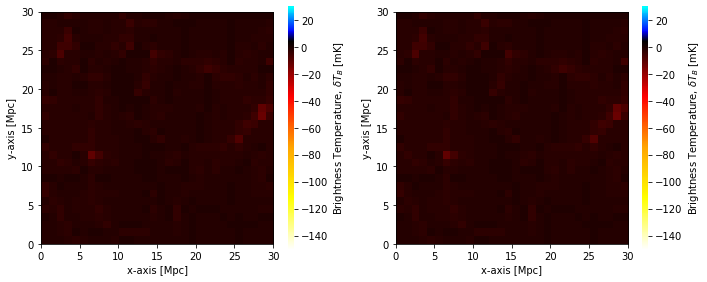

In [23]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(coeval, ax=ax[0], fig=fig)
plotting.coeval_sliceplot(brightness_temp_z25, ax=ax[1], fig=fig)
plt.tight_layout()

Of course, we could have pulled the cached data from a higher redshift:

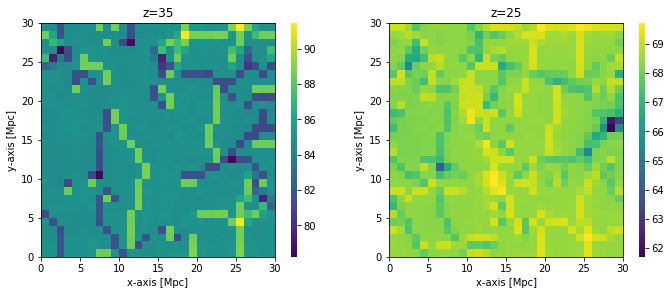

In [30]:
st_z35 = coeval.get_cached_data(redshift=35.0, kind='spin_temp', load_data=True)
st_z25 = coeval.get_cached_data(redshift=25.0, kind='spin_temp', load_data=True)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(st_z35, ax=ax[0], kind='Ts_box')
ax[0].set_title("z=35")
plotting.coeval_sliceplot(st_z25, ax=ax[1], kind='Ts_box')
ax[1].set_title("z=25")
plt.tight_layout();

Here we see evolution in the spin temperature field. Note that we can't look at the brightness temperature field at $z=25$ because it was never saved as part of the evolution of the coeval box (only the ionization field and spin temperature field are saved). This is different in `run_lightcone` -- all boxes are cached at every evaluated redshift for the lightcone.

<KeysViewHDF5 ['cache']>
<KeysViewHDF5 ['init', 'perturb_field']>
<KeysViewHDF5 ['z25.00']>
<KeysViewHDF5 ['z0.00']>


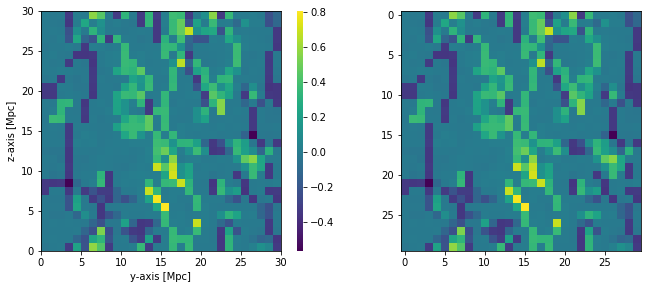

In [8]:
with h5py.File(folderdata+"/"+filename, "r") as file:
    print(file.keys())    
    print(file["cache"].keys()) #this will give you the kinds that were saved    
    print(file["cache"]["perturb_field"].keys()) #this will give you the z for this kind
    print(file["cache"]["init"].keys()) #ICs appear as z=0 as they do not depend on z
    delta_pert= list(file["cache"]["perturb_field"]["z25.00"]["density"])


from scipy import ndimage
    
fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(coeval, ax=ax[0], fig=fig, kind="density", slice_axis=0);
rotated_delta = ndimage.rotate(delta_pert[0], 90) #the coeval boxes are rotated w.r.t. numpy array
im1=ax[1].imshow(rotated_delta, origin="upper")
plt.tight_layout() #identical!

## Accessing Cached Data from a `Lightcone`

The process is essentially exactly the same for a lightcone:

In [31]:
brightness_temp_z25 = lightcone.get_cached_data(redshift=25.0, kind='brightness_temp', load_data=True)
brightness_temp_z35 = lightcone.get_cached_data(redshift=35.0, kind='brightness_temp', load_data=True)

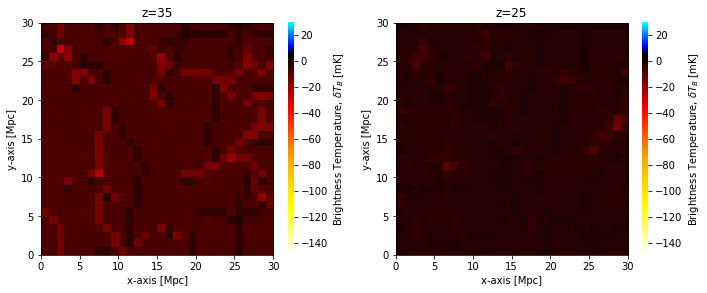

In [32]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(brightness_temp_z35, ax=ax[0])
ax[0].set_title("z=35")
plotting.coeval_sliceplot(brightness_temp_z25, ax=ax[1])
ax[1].set_title("z=25")
plt.tight_layout();

Note that this time, we are able to access the brightness temperature data from the cache, because lightcones save it all.

In fact, we could go further than this, and plot all the evaluated brightness temperatures. We can get the list of redshifts evaluated from the lightcone directly as `node_redshifts`:

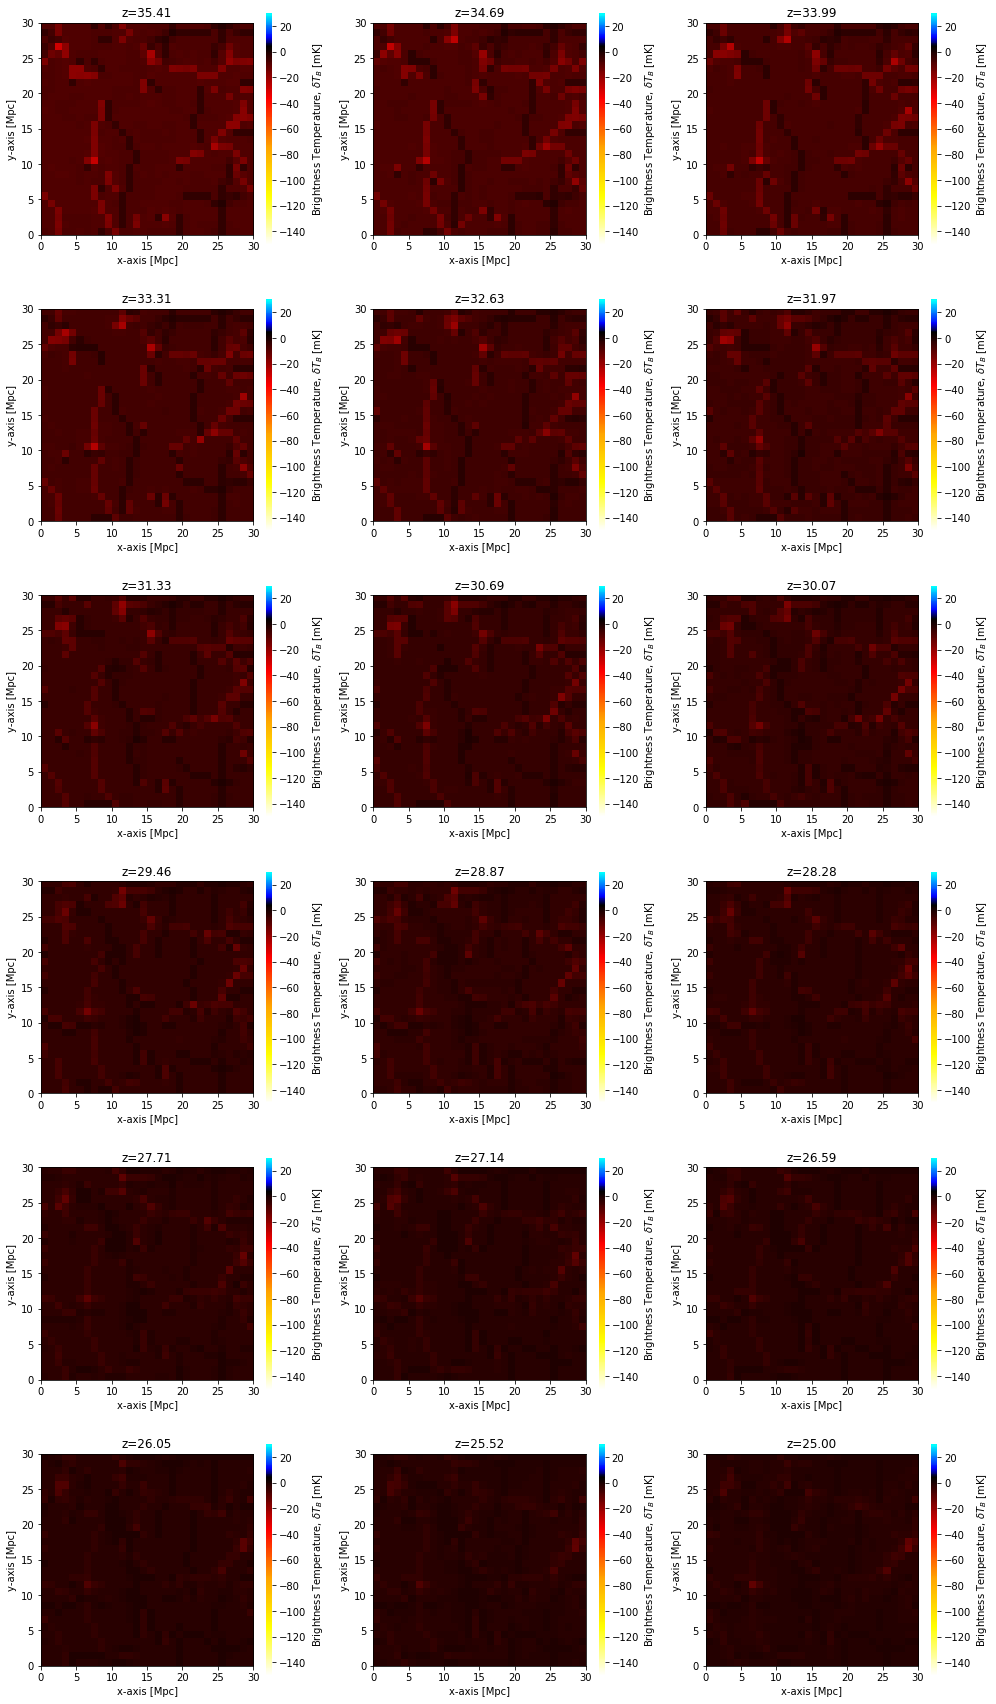

In [35]:
fig, ax = plt.subplots(len(lightcone.node_redshifts)//3, 3, figsize=(14,4*len(lightcone.node_redshifts)//3))

for i, z in enumerate(lightcone.node_redshifts):
    Tbz = lightcone.get_cached_data(redshift=z, kind='brightness_temp', load_data=True)
    plotting.coeval_sliceplot(Tbz, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(f"z={z:.2f}")
plt.tight_layout()

To illustrate another way of accessing these cached boxes, we can simply run `run_coeval` at a particular redshift, with the same input arguments. Let's choose about $z\sim30$:

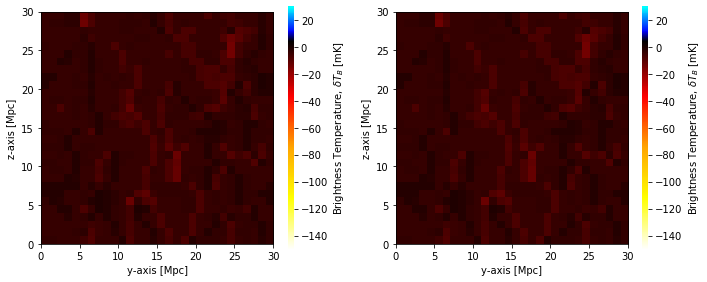

In [47]:
z30 = lightcone.node_redshifts[8] # the closest to 30

# Run the coeval. This will just find the box in cache, since it has exactly the same parameters.
coeval_z30 = p21c.run_coeval(
    redshift = z30,
    user_params = {"HII_DIM": 30, "BOX_LEN": 30},
    flag_options={"USE_TS_FLUCT": True},
    random_seed=1978,
    write=False
)

# Compare that to what we get from the lightcone cache
lc_z30 = lightcone.get_cached_data(redshift=30, kind='brightness_temp', load_data=True)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(coeval_z30, ax=ax[0])
plotting.coeval_sliceplot(lc_z30, ax=ax[1])
plt.tight_layout()

These are exactly the same. Note that in fact, the data comes from exactly the same file (the lightcone 'cache' is just a pointer to the standard file cache, just easier to access).

## Gathering cached data into one file

As we've already noted, when you use `get_cached_data`, the `Coeval` or `Lightcone` objects just know how to access a specific cached file -- usually found in your configured cache directory. This can be a little brittle -- if the cache files are removed, the `Coeval` object won't be able to access that data any more. To protect against this, you can `gather` all the evolutionary data into a single file. It's typically easiest if you first save the lightcone:

In [79]:
fname = lightcone.save(fname='lightcone.h5', direc='_cache')

Then, you can gather the cached data into that file:

In [80]:
lightcone.gather(
    fname=fname,
    kinds=("brightness_temp", "init"),
    direc='_cache',
);

The above gathered the brightness temperature and initial conditions data, and saved it into the file `_cache/lightcone.h5`. The `kinds` can be any of those allowed in `get_cached_data`. You can also call it again to gather more data:

In [76]:
lightcone.gather(fname=fname, kinds=('ionized_box',));

The original cached data files are left on-disk, which duplicates data. If you're sure you want to remove them, pass `clean=True` to `gather`.

The structure of the gathered data in the file is the following:

In [64]:
with h5py.File(fname, "r") as fl:
    print(fl['cache'].keys())
    print(fl['cache']['brightness_temp'].keys())
    print(fl['cache']['brightness_temp']['z25.00'].keys())
    
    tb_25 = fl['cache']['brightness_temp']['z25.00']['brightness_temp'][...]

<KeysViewHDF5 ['brightness_temp', 'init', 'ionized_box']>
<KeysViewHDF5 ['z25.00', 'z25.52', 'z26.05', 'z26.59', 'z27.14', 'z27.71', 'z28.28', 'z28.87', 'z29.46', 'z30.07', 'z30.69', 'z31.33', 'z31.97', 'z32.63', 'z33.31', 'z33.99', 'z34.69', 'z35.41']>
<KeysViewHDF5 ['brightness_temp']>


We've read in the brightness temperature at the final redshift. We can compare this to the coeval box directly evaluated there:

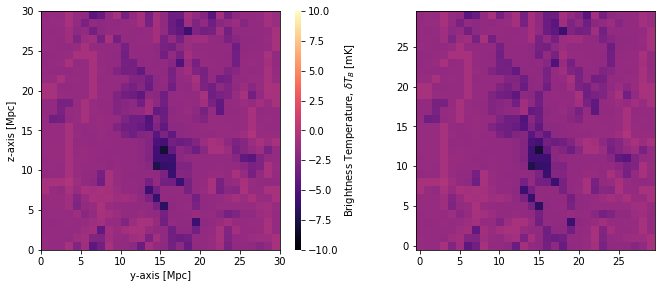

In [71]:
T21minplot=-10.0
T21maxplot=10.0

fig, ax = plt.subplots(1,2, figsize=(10,4))
plotting.coeval_sliceplot(
    coeval, 
    ax=ax[0], fig=fig, kind="brightness_temp", slice_axis=0,
    vmin=T21minplot, vmax=T21maxplot, cmap = "magma"
)
ax[1].imshow(
    tb_25.T[:, :, 0], 
    origin="lower", vmin=T21minplot, vmax=T21maxplot, cmap = "magma"
)
plt.tight_layout();

Again, they are equivalent.